## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import SqueezeNet1_1_Weights
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import Dataset, DataLoader, random_split
import copy

cudnn.benchmark = True
plt.ion()

Load data and create Dataloaders

In [13]:
from utils import SymbolDataset, encode_labels

data_dir = 'symbols_2000_1.npz'
data = np.load(data_dir)
images = data['images']
labels = data['labels']

class_names, labels_nums = encode_labels(labels)

images_tensor = torch.tensor(images).float()

# NOTE: maybe try different mean and stds?
# mean and std from imagenet are as follows:
#  - mean = 0.4453
#  - std  = 0.2692

# Calculate the mean and standard deviation
mean = images_tensor.mean()
std = images_tensor.std()

data_transforms = {
    'train': transforms.Compose([ # Add in transforms if needed, and add test set
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize(mean, std)
    ]),
}

# initialize symbol dataset training splits
dataset = SymbolDataset(images, labels_nums, transforms=data_transforms['train'])
print(images.shape)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# initialize dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)
}
dataset_sizes = {x: len(dataset) for x in ['train', 'val']}
class_names = np.unique(labels)
print(class_names)
num_classes = len(class_names)
print(num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(80372, 32, 32)
['(' ')' '+' '-' '0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '=' 'C' 'a' 'b'
 'd' 'dot' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'p' 'pi' 'q' 'r' 's'
 'slash' 't' 'u' 'v' 'w' 'x' 'y' 'z']
43


Visualize a batch of training data

torch.Size([64, 1, 32, 32])
torch.Size([3, 274, 274])


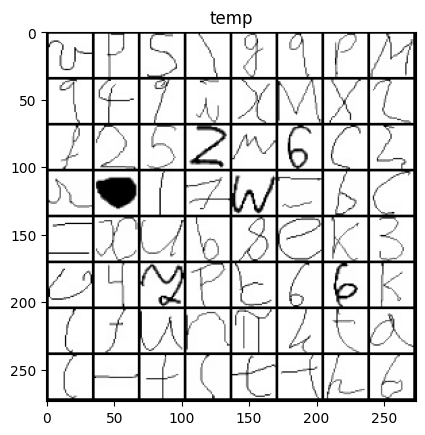

In [3]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title="temp")

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token=0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
             
            
            
            
            
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            count = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = np.repeat(inputs, 3, axis=1)
                count += len(labels)

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / count
            epoch_acc = running_corrects.double() / count

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token =1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Model Training

In [5]:
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(8192, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, num_classes)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x

In [6]:
from torchinfo import summary


model_ft = CIFAR10Model()
summary(model=model_ft, 
        verbose=0,
        input_size=(64, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CIFAR10Model (CIFAR10Model)              [64, 3, 32, 32]      [64, 43]             --                   True
├─Conv2d (conv1)                         [64, 3, 32, 32]      [64, 32, 32, 32]     896                  True
├─ReLU (act1)                            [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
├─Dropout (drop1)                        [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
├─Conv2d (conv2)                         [64, 32, 32, 32]     [64, 32, 32, 32]     9,248                True
├─ReLU (act2)                            [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
├─MaxPool2d (pool2)                      [64, 32, 32, 32]     [64, 32, 16, 16]     --                   --
├─Flatten (flat)                         [64, 32, 16, 16]     [64, 8192]           --                   --
├─Linear (fc3)          

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            # if it errors here u probably have to do the same grayscale to rgb stacking i did earlier
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs = inputs.repeat(1, 3, 1, 1)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft = model_ft.to(device)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.7046 Acc: 0.0484
val Loss: 3.5442 Acc: 0.1439

Epoch 1/24
----------
train Loss: 3.0508 Acc: 0.1925
val Loss: 2.6719 Acc: 0.2773

Epoch 2/24
----------
train Loss: 2.1199 Acc: 0.4226
val Loss: 1.6182 Acc: 0.6127

Epoch 3/24
----------
train Loss: 1.5563 Acc: 0.5786
val Loss: 1.2455 Acc: 0.6949

Epoch 4/24
----------
train Loss: 1.2644 Acc: 0.6553
val Loss: 1.0124 Acc: 0.7533

Epoch 5/24
----------
train Loss: 1.0740 Acc: 0.7045
val Loss: 0.8872 Acc: 0.7925

Epoch 6/24
----------
train Loss: 0.9396 Acc: 0.7354
val Loss: 0.8852 Acc: 0.7992

Epoch 7/24
----------
train Loss: 0.8129 Acc: 0.7720
val Loss: 0.7672 Acc: 0.8159

Epoch 8/24
----------
train Loss: 0.7890 Acc: 0.7791
val Loss: 0.7386 Acc: 0.8185

Epoch 9/24
----------
train Loss: 0.7772 Acc: 0.7823
val Loss: 0.7315 Acc: 0.8229

Epoch 10/24
----------
train Loss: 0.7593 Acc: 0.7851
val Loss: 0.7117 Acc: 0.8276

Epoch 11/24
----------
train Loss: 0.7495 Acc: 0.7904
val Loss: 0.7015 Acc: 0.8274

Ep

Model Visualization

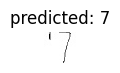

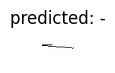

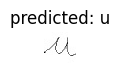

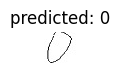

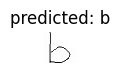

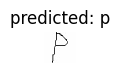

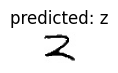

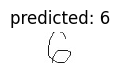

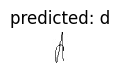

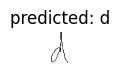

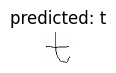

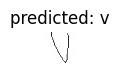

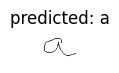

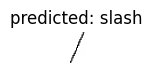

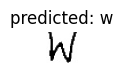

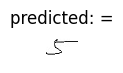

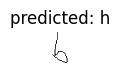

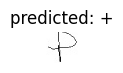

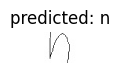

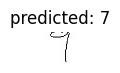

In [11]:
visualize_model(model_ft, 20)

In [12]:
torch.save(model_ft, 'transfer_model_custom_net.pth')